In [2]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [3]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INCO.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,2900.0,2950.0,2880.0,2900.0,2834.681641,8315300.0
1,2017-12-19,2940.0,2940.0,2890.0,2920.0,2854.230957,4371500.0
2,2017-12-20,2900.0,2900.0,2830.0,2850.0,2785.807617,10485500.0
3,2017-12-21,2870.0,2890.0,2840.0,2840.0,2776.032959,5395600.0
4,2017-12-22,2840.0,2850.0,2790.0,2800.0,2736.934082,4185500.0


In [4]:
print("Are there any 'MISSING VALUES / NULL / NaN' in the Dataset?\nAnswer:", df.isnull().sum().values.any())

Are there any 'MISSING VALUES / NULL / NaN' in the Dataset?
Answer: True


In [5]:
# Menghitung jumlah nilai yang hilang per kolom
missing_values_count = df.isna().sum()

# Menampilkan jumlah nilai yang hilang
print(missing_values_count)

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [6]:
df = df.dropna()

In [7]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [8]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,2900.0,2900.0,2950.0,2880.0
1,2017-12-19,2920.0,2940.0,2940.0,2890.0
2,2017-12-20,2850.0,2900.0,2900.0,2830.0
3,2017-12-21,2840.0,2870.0,2890.0,2840.0
4,2017-12-22,2800.0,2840.0,2850.0,2790.0
...,...,...,...,...,...
1489,2023-12-08,4360.0,4310.0,4430.0,4310.0
1490,2023-12-11,4190.0,4360.0,4370.0,4190.0
1491,2023-12-12,4220.0,4200.0,4250.0,4180.0
1492,2023-12-13,4020.0,4220.0,4230.0,4010.0


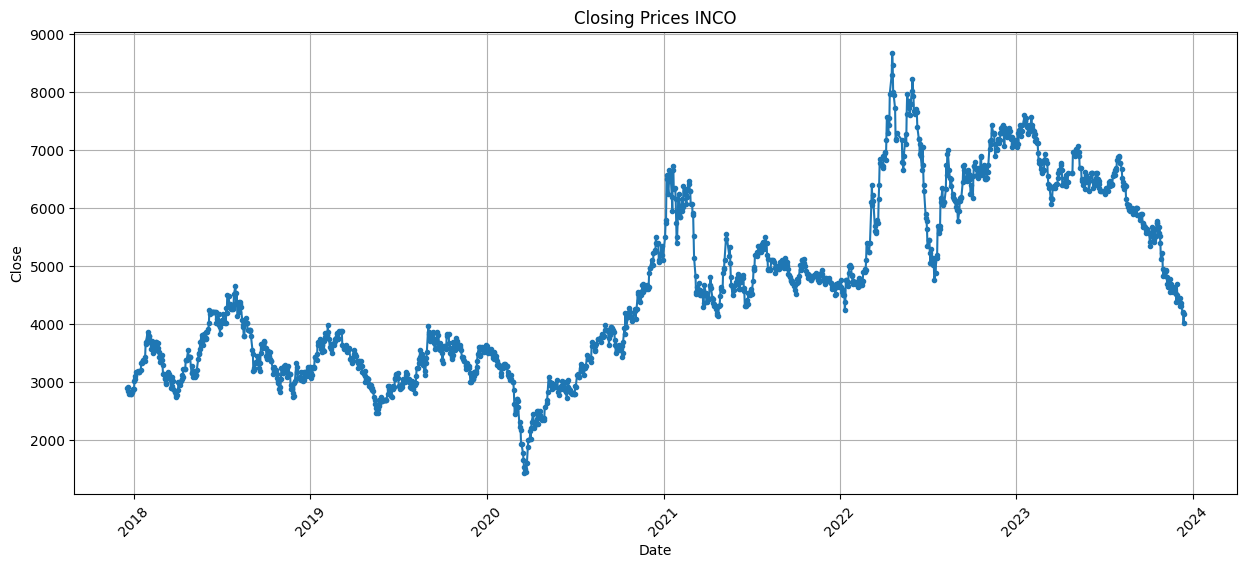

In [9]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices INCO')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

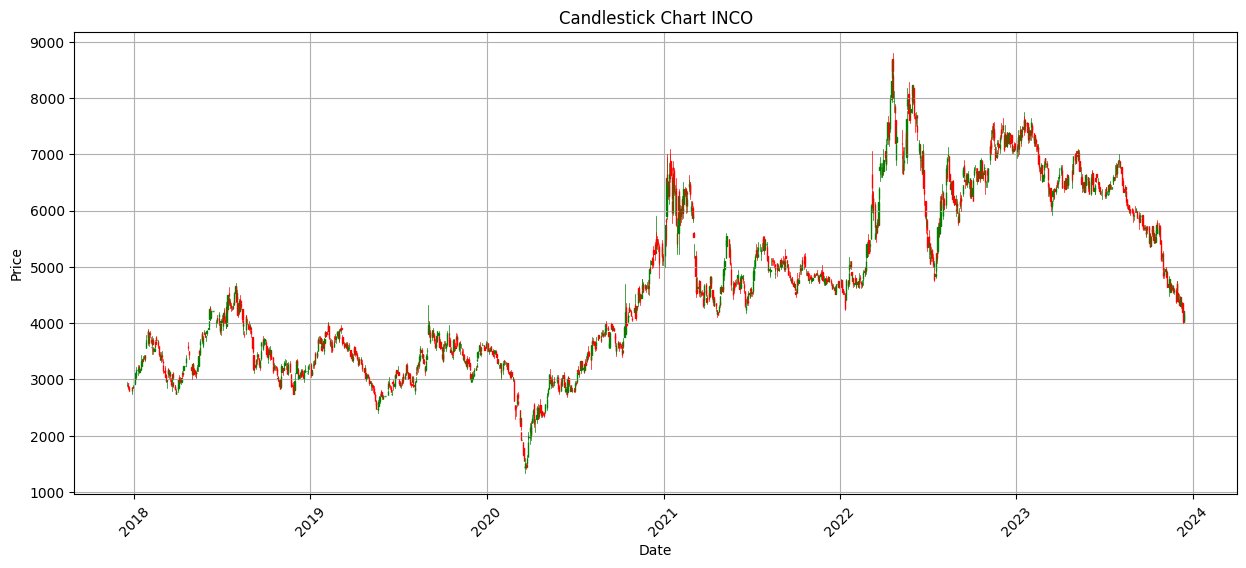

In [10]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart INCO')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

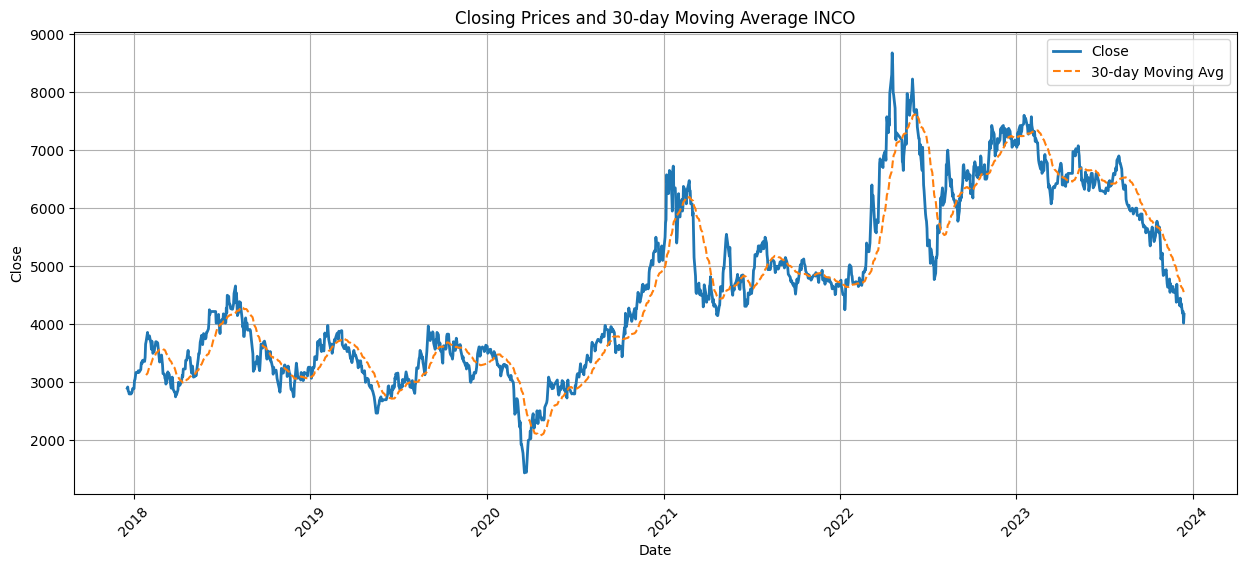

In [11]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average INCO')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,2900.0,2900.0,2950.0,2880.0
1,2017-12-19,2920.0,2940.0,2940.0,2890.0
2,2017-12-20,2850.0,2900.0,2900.0,2830.0
3,2017-12-21,2840.0,2870.0,2890.0,2840.0
4,2017-12-22,2800.0,2840.0,2850.0,2790.0


In [13]:
new_df = specific_df.reset_index()['Close']

In [14]:
new_df

0       2900.0
1       2920.0
2       2850.0
3       2840.0
4       2800.0
         ...  
1488    4360.0
1489    4190.0
1490    4220.0
1491    4020.0
1492    4170.0
Name: Close, Length: 1493, dtype: float64

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [16]:
data = scaled_data

top_20_data = data[:20]
print(top_20_data)

[[0.20179682]
 [0.20456116]
 [0.19488597]
 [0.1935038 ]
 [0.18797512]
 [0.18797512]
 [0.18797512]
 [0.19212163]
 [0.19212163]
 [0.20041465]
 [0.20041465]
 [0.21976503]
 [0.22252937]
 [0.23082239]
 [0.23911541]
 [0.23911541]
 [0.24049758]
 [0.24326192]
 [0.23911541]
 [0.24049758]]


Partisi Data

90%

In [46]:
train_size = int(len(scaled_data)*0.9) #90% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [47]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [48]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1283, 60)
(1283,)


Testing set size:-
(90, 60)
(90,)


(None, None)

In [49]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [50]:
Layer = 3

In [51]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [53]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [54]:
checkpoints = ModelCheckpoint(filepath= 'inco.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 10s 82ms/step - loss: 0.0979 - val_loss: 0.0087
Epoch 2/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0548 - val_loss: 0.0079
Epoch 3/100
41/41 [==============================] - 2s 57ms/step - loss: 0.0456 - val_loss: 0.0076
Epoch 4/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0403 - val_loss: 0.0025
Epoch 5/100
41/41 [==============================] - 3s 62ms/step - loss: 0.0353 - val_loss: 0.0058
Epoch 6/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0285 - val_loss: 0.0033
Epoch 7/100
41/41 [==============================] - 3s 63ms/step - loss: 0.0318 - val_loss: 0.0044
Epoch 8/100
41/41 [==============================] - 3s 68ms/step - loss: 0.0253 - val_loss: 0.0020
Epoch 9/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0230 - val_loss: 0.0034
Epoch 10/100
41/41 [==============================] - 3s 65ms/step - loss: 0.0225 - val_loss: 0.001

In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 16ms/step


In [56]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [57]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.0671884646989357
0.031101093250989552


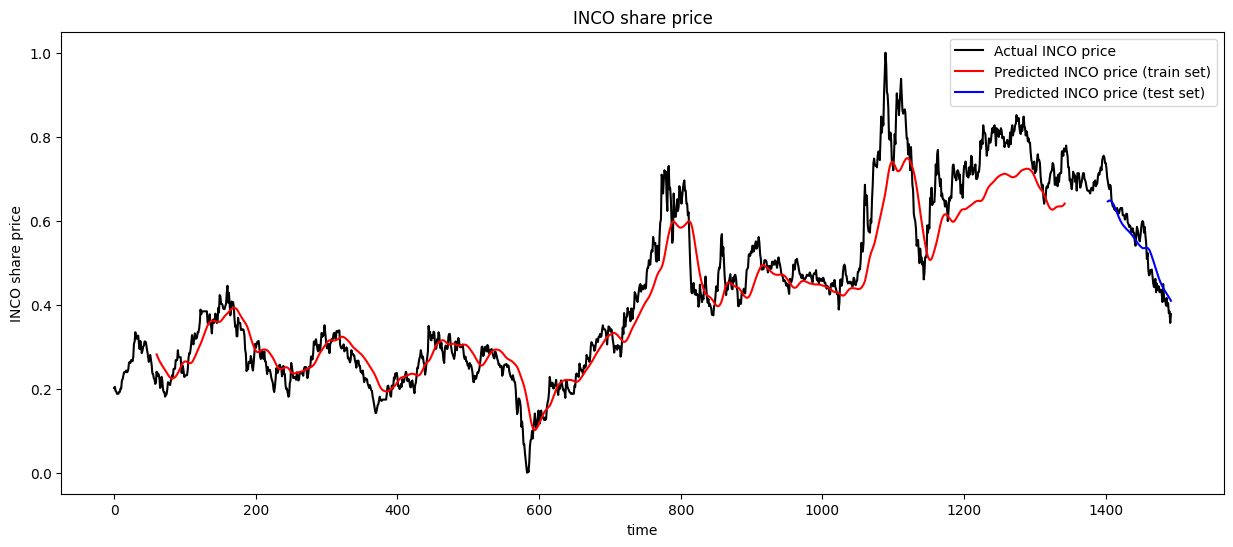

In [58]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INCO price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INCO price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INCO price (test set)")

plt.title(f"INCO share price")
plt.xlabel("time")
plt.ylabel(f"INCO share price")
plt.legend()
plt.show()

In [59]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 49ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 4401.8896484375
Day 2: Predicted Price = 4379.89013671875
Day 3: Predicted Price = 4359.92236328125
Day 4: Predicted Price = 4342.4658203125
Day 5: Predicted Price = 4327.5146484375
Day 6: Predicted Price = 4314.81689453125
Day 7: Predicted Price = 4304.02099609375
Day 8: Predicted Price = 4294.7568359375
Day 9: Predicted Price = 4286.685546875
Day 10: Predicted Price = 4279.515625
Day 11: Predicted Price = 4273.01220703125
Day 12: Predicted Price = 4266.99267578125
Day 13: Predicted Price = 4261.31982421875
Day 14: Predicted Price = 4255.8935546875
Day 15: Predicted Price = 4250.6455078125
Day 16: Predicted Price = 4245.52734375
Day 17: Predicted Price = 4240.5078125
Day 18: Predicted Price = 4235.56787109375
Day 19: Predicted Price = 4230.6953125
Day 20: Predicted Price = 4225.8837890625
Day 21: Predicted Price = 4221.13037109375
Day 22: Predicted Price = 4216.43310546875
Da

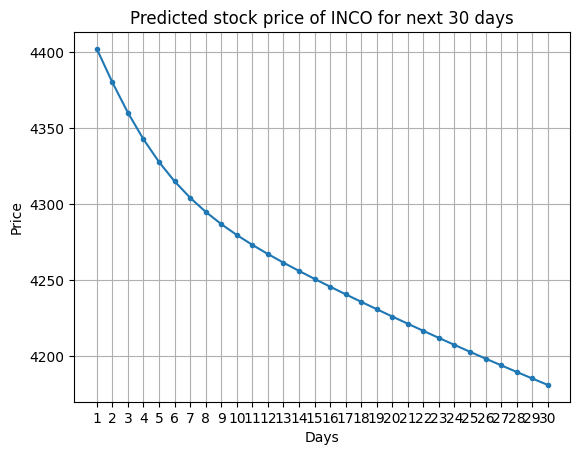

In [60]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INCO for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [61]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 24ms/step - loss: 9.6728e-04
Validation Loss: 0.0009672781452536583
Validation MSE Loss: 0.0009672781452536583


In [62]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.0671884646989357
Testing RMSE: 0.031101093250989552


80%

In [63]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [64]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [65]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1134, 60)
(1134,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [66]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [67]:
Layer = 3

In [68]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [70]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [71]:
checkpoints = ModelCheckpoint(filepath= 'inco.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 11s 112ms/step - loss: 0.0818 - val_loss: 0.0236
Epoch 2/100
36/36 [==============================] - 2s 70ms/step - loss: 0.0427 - val_loss: 0.0264
Epoch 3/100
36/36 [==============================] - 3s 70ms/step - loss: 0.0326 - val_loss: 0.0288
Epoch 4/100
36/36 [==============================] - 3s 70ms/step - loss: 0.0270 - val_loss: 0.0305
Epoch 5/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0294 - val_loss: 0.0089
Epoch 6/100
36/36 [==============================] - 2s 69ms/step - loss: 0.0235 - val_loss: 0.0174
Epoch 7/100
36/36 [==============================] - 3s 74ms/step - loss: 0.0229 - val_loss: 0.0100
Epoch 8/100
36/36 [==============================] - 2s 65ms/step - loss: 0.0188 - val_loss: 0.0058
Epoch 9/100
36/36 [==============================] - 2s 68ms/step - loss: 0.0187 - val_loss: 0.0087
Epoch 10/100
36/36 [==============================] - 2s 65ms/step - loss: 0.0172 - val_loss: 0.01

In [72]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 19ms/step


In [73]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [74]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04648477218972314
0.03468874727811769


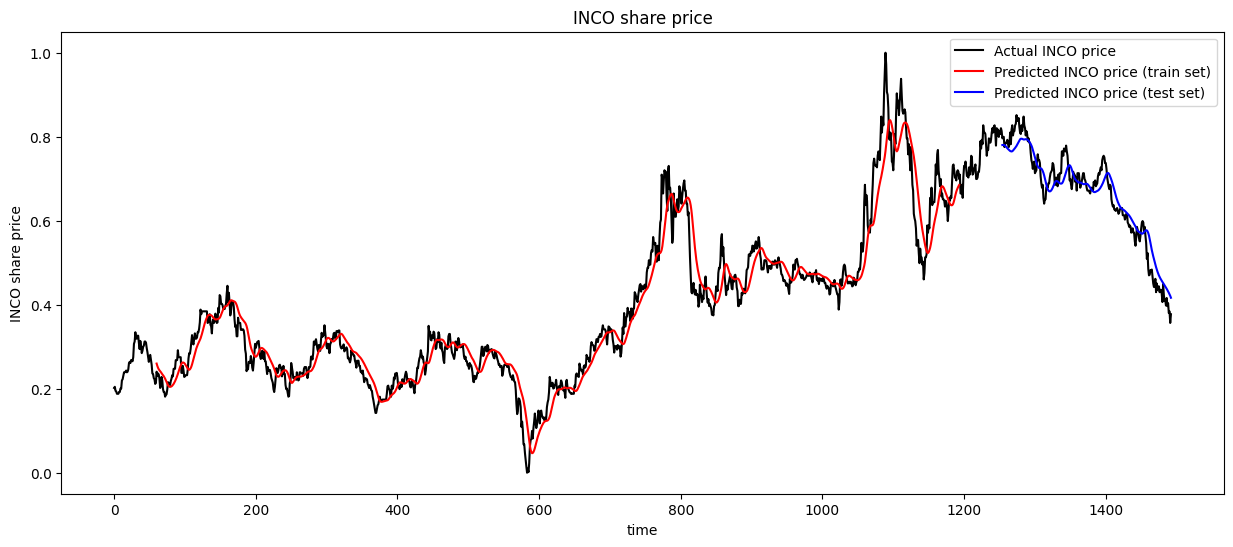

In [75]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INCO price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INCO price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INCO price (test set)")

plt.title(f"INCO share price")
plt.xlabel("time")
plt.ylabel(f"INCO share price")
plt.legend()
plt.show()

In [76]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 32ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 4454.0478515625
Day 2: Predicted Price = 4426.47802734375
Day 3: Predicted Price = 4407.7548828125
Day 4: Predicted Price = 4397.6455078125
Day 5: Predicted Price = 4394.32275390625
Day 6: Predicted Price = 4395.62890625
Day 7: Predicted Price = 4399.6826171875
Day 8: Predicted Price = 4405.10009765625
Day 9: Predicted Price = 4410.9873046875
Day 10: Predicted Price = 4416.83837890625
Day 11: Predicted Price = 4422.421875
Day 12: Predicted Price = 4427.671875
Day 13: Predicted Price = 4432.60888671875
Day 14: Predicted Price = 4437.2939453125
Day 15: Predicted Price = 4441.796875
Day 16: Predicted Price = 4446.17724609375
Day 17: Predicted Price = 4450.4814453125
Day 18: Predicted Price = 4454.7421875
Day 19: Predicted Price = 4458.97900390625
Day 20: Predicted Price = 4463.205078125
Day 21: Predicted Price = 4467.427734375
Day 22: Predicted Price = 4471.65087890625
Day 23: Pr

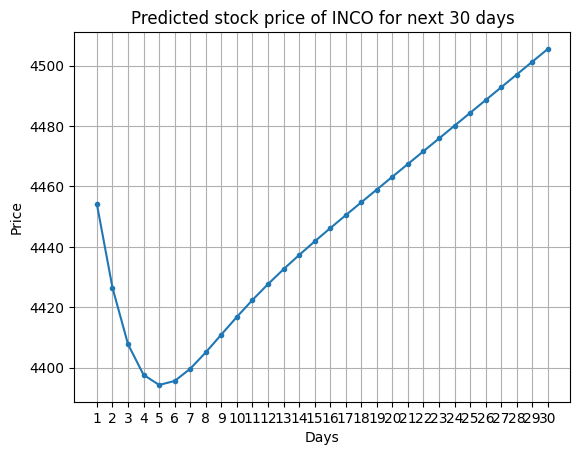

In [77]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INCO for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [78]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 23ms/step - loss: 0.0012
Validation Loss: 0.001203309278935194
Validation MSE Loss: 0.001203309278935194


In [79]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04648477218972314
Testing RMSE: 0.03468874727811769


70%

In [80]:
train_size = int(len(scaled_data)*0.7) #70% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [81]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [82]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(985, 60)
(985,)


Testing set size:-
(388, 60)
(388,)


(None, None)

In [83]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [84]:
Layer = 3

In [85]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [87]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [88]:
checkpoints = ModelCheckpoint(filepath= 'inco.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
31/31 [==============================] - 11s 115ms/step - loss: 0.0622 - val_loss: 0.0964
Epoch 2/100
31/31 [==============================] - 2s 66ms/step - loss: 0.0329 - val_loss: 0.0587
Epoch 3/100
31/31 [==============================] - 2s 66ms/step - loss: 0.0245 - val_loss: 0.0098
Epoch 4/100
31/31 [==============================] - 2s 79ms/step - loss: 0.0236 - val_loss: 0.0416
Epoch 5/100
31/31 [==============================] - 2s 79ms/step - loss: 0.0168 - val_loss: 0.0147
Epoch 6/100
31/31 [==============================] - 2s 73ms/step - loss: 0.0160 - val_loss: 0.0277
Epoch 7/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 8/100
31/31 [==============================] - 2s 79ms/step - loss: 0.0145 - val_loss: 0.0241
Epoch 9/100
31/31 [==============================] - 2s 66ms/step - loss: 0.0123 - val_loss: 0.0240
Epoch 10/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0121 - val_loss: 0.02

In [89]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

13/13 [==============================] - 0s 19ms/step


In [90]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [91]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.054405705417171164
0.09907480929187323


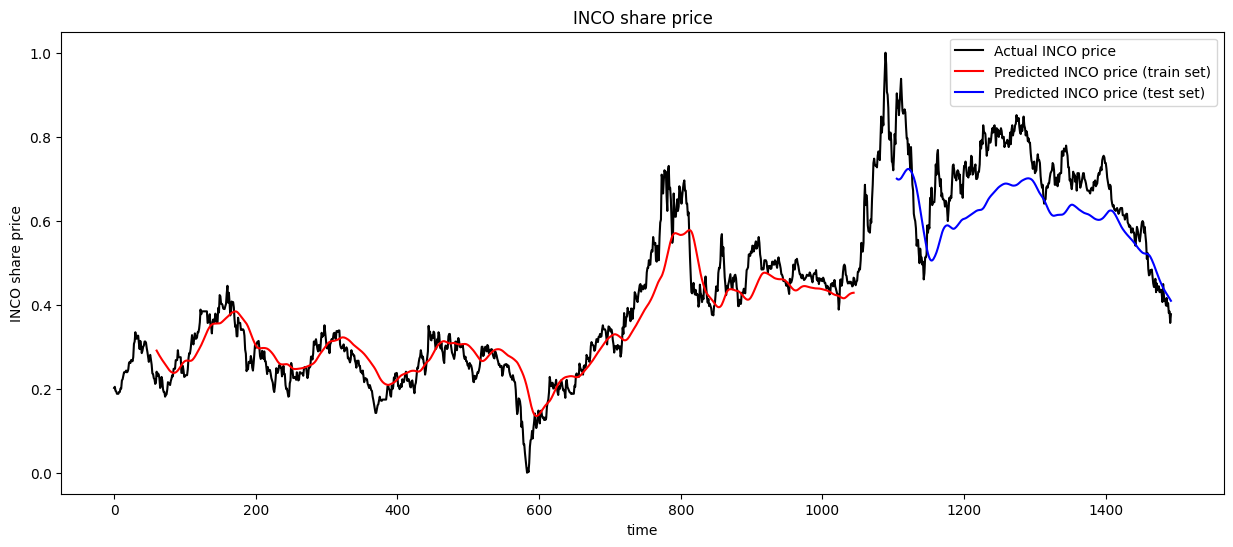

In [92]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INCO price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INCO price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INCO price (test set)")

plt.title(f"INCO share price")
plt.xlabel("time")
plt.ylabel(f"INCO share price")
plt.legend()
plt.show()

In [93]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 31ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 4401.63916015625
Day 2: Predicted Price = 4381.35009765625
Day 3: Predicted Price = 4362.158203125
Day 4: Predicted Price = 4344.49072265625
Day 5: Predicted Price = 4328.49609375
Day 6: Predicted Price = 4314.1455078125
Day 7: Predicted Price = 4301.2998046875
Day 8: Predicted Price = 4289.7734375
Day 9: Predicted Price = 4279.3671875
Day 10: Predicted Price = 4269.88330078125
Day 11: Predicted Price = 4261.14892578125
Day 12: Predicted Price = 4253.01025390625
Day 13: Predicted Price = 4245.3388671875
Day 14: Predicted Price = 4238.03564453125
Day 15: Predicted Price = 4231.02783203125
Day 16: Predicted Price = 4224.2578125
Day 17: Predicted Price = 4217.6787109375
Day 18: Predicted Price = 4211.25830078125
Day 19: Predicted Price = 4204.97265625
Day 20: Predicted Price = 4198.80322265625
Day 21: Predicted Price = 4192.74267578125
Day 22: Predicted Price = 4186.78466796875
D

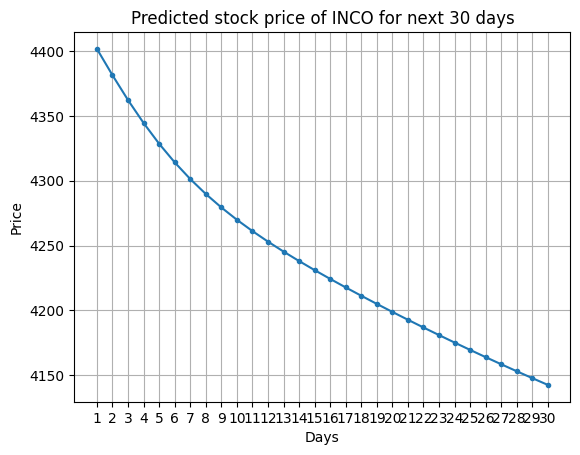

In [94]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INCO for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [95]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



13/13 [==============================] - 0s 24ms/step - loss: 0.0098
Validation Loss: 0.009815818630158901
Validation MSE Loss: 0.009815818630158901


In [96]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.054405705417171164
Testing RMSE: 0.09907480929187323


60%

In [97]:
train_size = int(len(scaled_data)*0.6) #60% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [98]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [99]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(835, 60)
(835,)


Testing set size:-
(538, 60)
(538,)


(None, None)

In [100]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [101]:
Layer = 3

In [102]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [103]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [104]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [105]:
checkpoints = ModelCheckpoint(filepath= 'inco.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
27/27 [==============================] - 9s 128ms/step - loss: 0.0545 - val_loss: 0.0644
Epoch 2/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0287 - val_loss: 0.0378
Epoch 3/100
27/27 [==============================] - 2s 71ms/step - loss: 0.0231 - val_loss: 0.0477
Epoch 4/100
27/27 [==============================] - 2s 73ms/step - loss: 0.0215 - val_loss: 0.0276
Epoch 5/100
27/27 [==============================] - 2s 73ms/step - loss: 0.0199 - val_loss: 0.0372
Epoch 6/100
27/27 [==============================] - 2s 71ms/step - loss: 0.0165 - val_loss: 0.0499
Epoch 7/100
27/27 [==============================] - 2s 84ms/step - loss: 0.0133 - val_loss: 0.0254
Epoch 8/100
27/27 [==============================] - 3s 101ms/step - loss: 0.0141 - val_loss: 0.0235
Epoch 9/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0135 - val_loss: 0.0311
Epoch 10/100
27/27 [==============================] - 2s 69ms/step - loss: 0.0124 - val_loss: 0.02

In [106]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

17/17 [==============================] - 1s 25ms/step


In [107]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [108]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04995420873149659
0.07768724063197884


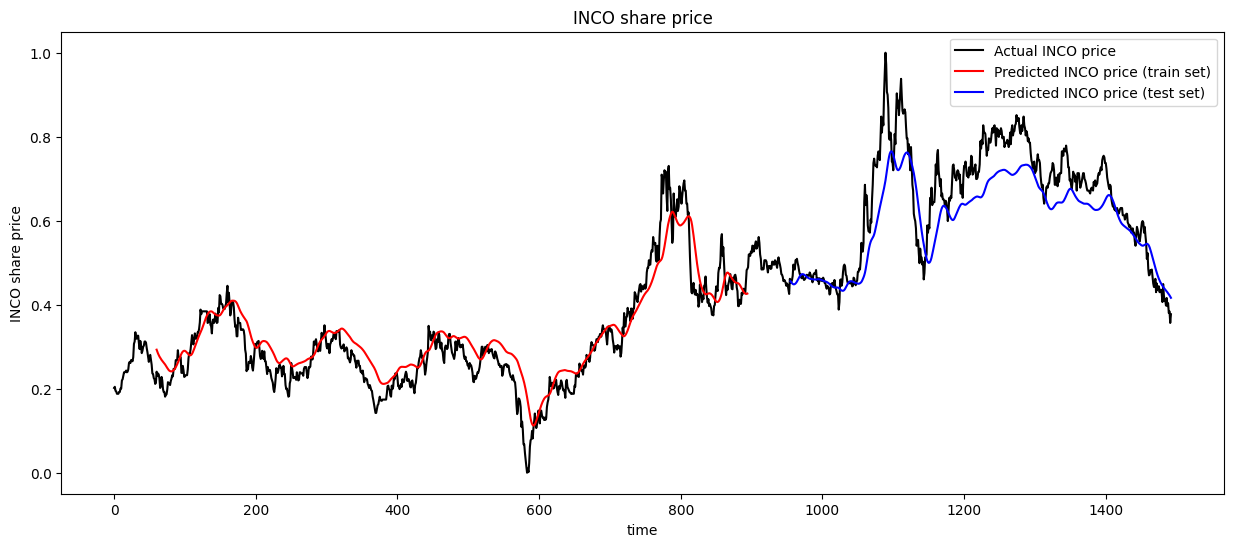

In [109]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INCO price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INCO price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INCO price (test set)")

plt.title(f"INCO share price")
plt.xlabel("time")
plt.ylabel(f"INCO share price")
plt.legend()
plt.show()

In [110]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 47ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 4453.2080078125
Day 2: Predicted Price = 4431.8291015625
Day 3: Predicted Price = 4414.02734375
Day 4: Predicted Price = 4400.5234375
Day 5: Predicted Price = 4391.1865234375
Day 6: Predicted Price = 4385.458984375
Day 7: Predicted Price = 4382.62109375
Day 8: Predicted Price = 4381.958984375
Day 9: Predicted Price = 4382.8408203125
Day 10: Predicted Price = 4384.7548828125
Day 11: Predicted Price = 4387.3125
Day 12: Predicted Price = 4390.2314453125
Day 13: Predicted Price = 4393.318359375
Day 14: Predicted Price = 4396.44970703125
Day 15: Predicted Price = 4399.5517578125
Day 16: Predicted Price = 4402.583984375
Day 17: Predicted Price = 4405.529296875
Day 18: Predicted Price = 4408.38134765625
Day 19: Predicted Price = 4411.14306640625
Day 20: Predicted Price = 4413.8203125
Day 21: Predicted Price = 4416.41943359375
Day 22: Predicted Price = 4418.94873046875
Day 23: Predict

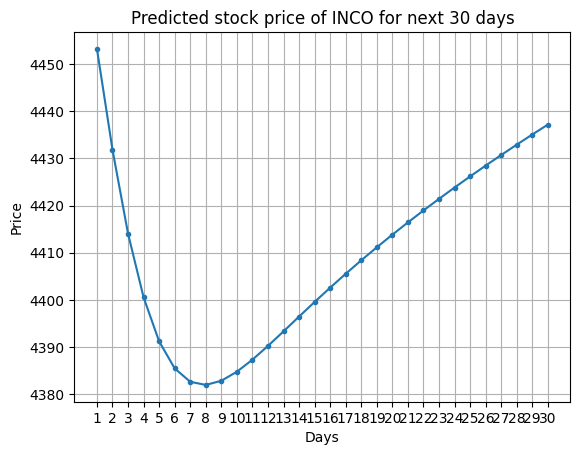

In [111]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INCO for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [112]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



17/17 [==============================] - 1s 29ms/step - loss: 0.0060
Validation Loss: 0.006035307887941599
Validation MSE Loss: 0.006035307887941599


In [113]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04995420873149659
Testing RMSE: 0.07768724063197884


: 